**Optimizacion Industrial con Computacion Evolutiva**

<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

<b>
Proyecto final: Usando computación evolutiva para asignación de ítems a bins 
</b>

Grupo 2:
- 
- 
- 
- 

## DESAFÍO: Usando computación evolutiva para asignación de ítems a bins

En este proyecto se pide implementar un algoritmo evolutivo para asignar un conjunto de ítems de diferentes tamaños a un conjunto de Bins. Cada Bin tiene un tamaño máximo pre-especificado. La idea es que se minimice la suma total del tamaño de los ítems que no pudieron ser asignados junto con la suma total de áreas no usadas en cada Bin.

Se pide:
- Plantear un diseño del algoritmo genético, proponiendo una representación adecuada de
los individuos y operadores genéticos. Al menos dos operadores de cruzamiento y dos de
mutación deberían ser probados.
- Elaborar experimentos para evaluar el AG con los diferentes operadores de cruzamiento
implementados (deshabilitar mutación para ello) y luego con la mutación habilitada a
diferentes tasas de mutación. Se sugiere 10 individuos como tamaño de población. Para
cada configuración a evaluar se debe hacer al menos 10 corridas para sacar conclusiones
estadísticamente válidas. Probar bajo diferentes escenarios de cantidades de bins e ítems.
La generación de ítems también puede ser hecha partiendo los bins en n pedazos y
corriendo el AG para ver como reconstruye
- Realizar el análisis de resultados y elaborar sus conclusiones sobre el desempeño de los
operadores y efectos de parámetros y cuál sería la configuración más adecuada para
resolver el problema.
- Informe de lo realizado y códigos con las implementaciones 



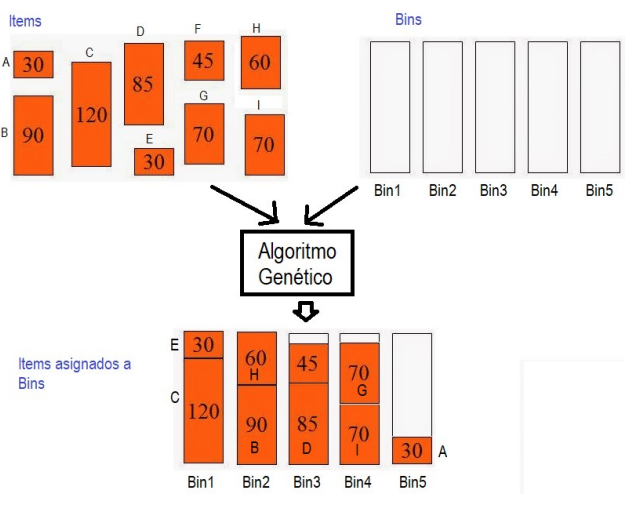

Dada una lista de ítems que están conformadas por un nombre y tamaño ('name', 'size'):

    [('A', 30), ('B', 90), ('C',120), ('D',85), ('E':30), ('F',45), ('G',70),('H',60),('I',70)]

Un individuo del algoritmo genético (AG) tiene un cromosoma que es una lista de elementos, donde cada gen i es un número correspondiente al índice la lista de ítems. El cromosoma es una permutación de la lista ítems.

    [2      4     1      7      3     5     8      6      0] 

Este cromosoma representa la secuencia en que los ítems deben ir colocándose desde el bin 0 hasta el último.

    [('C', 120), ('E', 30), ('B',90), ('H',60), ('D':85), ('F',45), ('I',70),('G',60),('A',30)]

## Librerías a utilizar

In [ ]:
import sys
import time
import random
import numpy as np
from copy import deepcopy
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math

## Clase Item

Un objeto de clase Item almacena el nombre del ítem y el tamaño que ocupa.

In [ ]:
class Item(object):
  def __init__(self, name, size):
    self.name = name # Nombre del ítem
    self.size = size # Tamaño que ocupa el ítem

  def __str__(self):
    return f'{self.name}:{self.size}'

## Definición de la estructura de un individuo en el AG con sus operadores genéticos


In [ ]:
class Individual(object):   
   
    def __init__(self, chromosome):
            self.chromosome = chromosome[:]
            self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
     
    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other"
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)

        return [ind1, ind2]     
    
    def crossover_orderpermutation(self, other):
        "Uniform order-based crossover. Genera 2 cromosomas hijos  que tambien deben ser permutaciones" 
        "Retorna dos nuevos individuos del cruzamiento de permutacion entre self y other" 
        "Escoge aleatoriamente la mitad de posiciones del cromosoma self y lo copia a un hijo ind1 en las mismas posiciones" 
        "Los numeros faltantes los copia de other en el mismo orden en que aparecen en other "
        "El hijo ind2 se crea de la misma forma intercambiando self por other"
        
        pos_constantes = []
        pos_constantes = random.sample(range(len(self.chromosome)),len(self.chromosome)//2)
        cromosomo1 = [-1]*len(self.chromosome) 
        cromosomo2 = [-1]*len(self.chromosome) 
        
        for index in pos_constantes:
            cromosomo1[index]= self.chromosome[index]
            cromosomo2[index] = other.chromosome[index]
            
        for i in range(len(self.chromosome)):
            if(cromosomo1[i] == -1):
                for j in range(len(other.chromosome)):
                    if other.chromosome[j] not in cromosomo1:
                        cromosomo1[i] = other.chromosome[j]
                        break
                        
                for j in range(len(self.chromosome)):
                    if self.chromosome[j] not in cromosomo2:
                        cromosomo2[i] = self.chromosome[j]
                        break          
        
        ind1 = Individual(cromosomo1)
        ind2 = Individual(cromosomo2)
        return [ind1, ind2]          
    
    def mutate_position(self): 
        """       
        Mutación 'position':
        Cambia aleatoriamente un alelo de un gen.
        """
        mutated_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(1,len(mutated_chromosome)) 
        newAllele = random.randrange(1,len(mutated_chromosome))
        mutated_chromosome[mutGene] = newAllele

        return Individual(mutated_chromosome)    
        
    def mutate_swap(self):
        """
        Mutación 'swap':
        Escoge dos genes e intercambia sus alelos
        """
        mutated_chromosome = deepcopy(self.chromosome[:])
        mutGen1 = random.randrange(1,len(mutated_chromosome))
        mutGen2 = random.randrange(1,len(mutated_chromosome))
        temp = mutated_chromosome[mutGen1]
        mutated_chromosome[mutGen1] = mutated_chromosome[mutGen2]
        mutated_chromosome[mutGen2] = temp
        return Individual(mutated_chromosome)

    def mutate_insertion(self):
        """
        Mutación 'insertion': 
        Se elige 2 genes aleatoriamente, se mueve el segundo al lado del primero
        y luego se desplaza el resto
        """
        chromosome = deepcopy(self.chromosome[:])

        # Sacamos 2 genes aleatorios del cromosoma
        # El primer gen elegido no incluye el último gen del cromosoma
        first_gen_index = random.randint(0,len(chromosome)-2)
        first_gen = chromosome[first_gen_index]

        # El segundo gen elegido se considera del índice del primer elegido en adelante
        second_gen_index = random.randint(first_gen_index+1, len(chromosome)-1)
        second_gen = chromosome[second_gen_index]

        # Se inicializa el cromosome mutado
        mutated_chromosome = [-1]*len(chromosome)

        # Agregamos primero los genes elegidos
        mutated_chromosome[first_gen_index] = first_gen
        # Se coloca el segundo gen al lado del primero
        mutated_chromosome[first_gen_index+1] = second_gen

        # Completamos los demás genes preservando el orden
        mutated_chromosome_index = 0

        # Se quita los genes seleccionados del cromosoma
        chromosome.remove(first_gen)
        chromosome.remove(second_gen)
        
        # Se agrega los genes que no fueron elegidos del cromosoma
        # conservando el orden
        chromosome_index = 0
        for index, gen in enumerate(mutated_chromosome):
          if gen==-1:
            mutated_chromosome[index] = chromosome[chromosome_index]
            chromosome_index+=1

        return Individual(mutated_chromosome)

    def __str__(self):
        return '[' + " ".join(str(c) for c in self.chromosome) + ']'

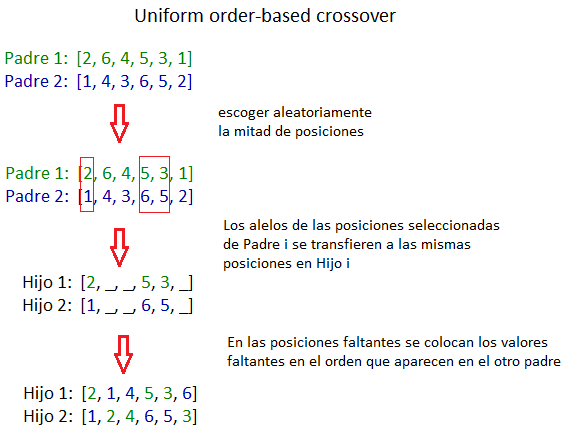

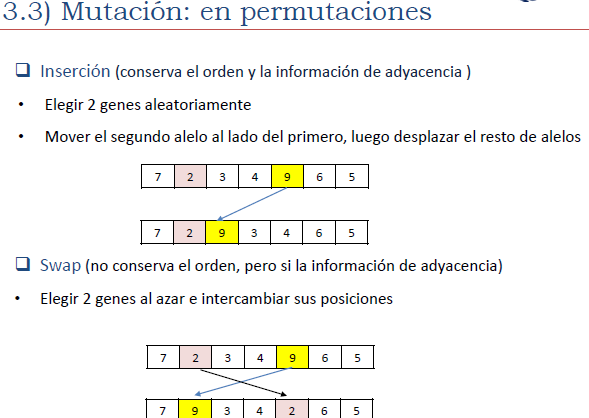

### Funciones para inicializar y visualizar Poblaciones

In [ ]:
def init_population(pop_number, size_chromosoma):
    population = []
    ## Crea la poblacion inicial con cromosomas aleatorios (permutaciones)
    for i in range(pop_number):
        new_chromosome = [j for j in range(size_chromosoma)]
        random.shuffle(new_chromosome)
        population.append(Individual(new_chromosome))
    return population

Clase para plasmar la información de un cromosoma a la representación gráfica de los bins con sus respectivos ítems.

In [ ]:
class Bins:
    def __init__(self, max_bins_size, items):
      """
      Constructor de la clase Bins
      Parameters:
      ----------
      max_bins_size list[int]: lista que contienen los tamaños máximos de cada bin
      items list[Item]: lista de ítems que colocarán en los bins
      """
      # El número de bins en total
      self.bins_number:int = len(max_bins_size)

      # La lista que contiene el tamaño de cada bin
      self.max_bins_size:list[int] = max_bins_size

      # La lista con los items que se irán colocando en los bins
      self.items:list[Item] = items
      
      # Se convierte la lista de bins del cromosoma a una lista agrupada para cada bin
      self.bins_content = self.process_items_list()


    def process_items_list(self):
      """
      Esta función recibe la lista de ítems que es el cromosoma y la convierte
      en una lista con información de cada bin. Cada elemento de esta lista
      es a su vez una lista con ítems que contiene dicho bin.
      Ejemplo de resultado:
      [
        [Item('A',30), Item('B',40)], # ítems de bin 0 
        [Item('C',60)], # ítems de bin 1
        [], # ítems de bin 2,
        ...
      ]
      """
      # Variable para monitorear el contenido del bin mientras se les va llenando de ítems
      bins_state = [0]*self.bins_number

      # Creamos una lista vacía que contendrá la lista de items de cada bin
      bins_content = []
      for _ in range(self.bins_number):
        bins_content.append([])
      bin_count = 0
      item_count = 0

      while(True):
        # Validación de contandor de bins
        if not(bin_count < self.bins_number):
          break
        # Validación de contador de items
        if not(item_count < len(self.items)):
          break

        # Se obtiene el item actual
        item = self.items[item_count]

        # Se valida que haya espacio para meter el item en el bin actual
        if bins_state[bin_count] + item.size <= self.max_bins_size[bin_count]:
          bins_state[bin_count] += item.size
          bins_content[bin_count].append(item)
          # Se incrementa el contandor de item para la siguiente iteración
          item_count+=1
        else:
          # Como no había espacio, se incrementa el contador del bin para pasar
          # al siguiente bin
          bin_count+=1

      return bins_content
    
    def print_items(self):
      """
      Imprime todos los ítems asociados a los bins en orden.
      """
      for item in self.items:
        print(item)

    def print_bins_content(self):
      """
      Muestra en texto el contenido de cada bin
      """
      for bin_index, bin_content in enumerate(self.bins_content):
        print("-"*30)
        print(f'Bin N°{bin_index+1}')
        for item in bin_content:
          print(item)

    def plot(self):
      """
      Crea un plot de los bins con su respectivo contenido y capacidad de tamaño.
      """
      # Se crea las etiquetas para los bins (eje x)
      x_labels = [f'Bin {i+1}' for i in range(self.bins_number)]

      bins_state = [0]*self.bins_number

      plt.figure(figsize=(10,6))

      # Barras para mostrar el tamaño de los bins
      plt.bar(x_labels, self.max_bins_size, color='w', edgeColor='gray')

      # Se itera sobre el contenido de cada bin
      for bin_index, bin_content in enumerate(self.bins_content):
        
        # Se itera sobre cada bin para tener los items que contiene
        bin_name = x_labels[bin_index]
        for item in bin_content:
          # Se coloca la barra
          plt.bar(bin_name, item.size, bottom=bins_state[bin_index])
          # Se agrega la etiqueta de texto a la barra
          plt.text(bin_name, bins_state[bin_index] + item.size//2, item, ha='center')
          # Se agrega al bin actual el tamaño del ítem para ir llenándolo
          bins_state[bin_index] += item.size

      plt.ylabel("Espacio en bins")
      plt.title(f"Asignación de ítems en bins #bins={self.bins_number}, #ítems={len(self.items)}")
      plt.show()

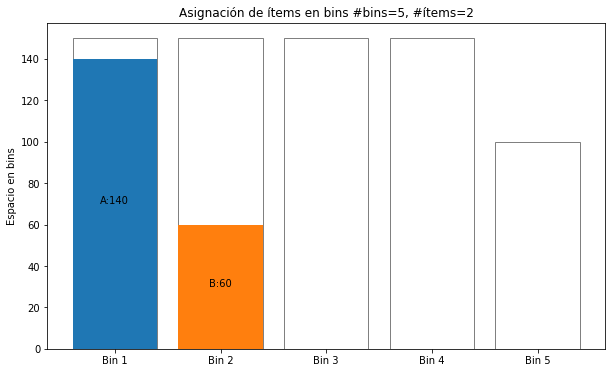

In [ ]:
bins = Bins([150, 150, 150, 150, 100], [Item('A',140), Item('B',60)])
bins.plot()

Funcion para mostrar una población y su fitness

In [ ]:
def display_population(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    data=pd.DataFrame(listaAG)
    data.columns = ['poblacion','fitness']
    return data

### Utilitarios

In [ ]:
def generate_items(items_num:int, max_item_size:int):
  """
  Función que genera una lista de ítems con sus respectivo nombres y tamaño que
  ocupan. El tamaño máximo que puede tener los ítems está definido por el parámetro
  max_item_size.

  Parameter:
  ----------
  items_num (int): cantidad de ítems a generar
  max_item_size (int): el tamaño máximo que puede tener un ítem

  Returns:
  items (list[Item]): una lista de objetos Item
  """
  items = []
  for i in range(items_num):
    # Se asigna al ítem una letra empezando de la 'A'
    name = chr(65+i)
    # Se genera un número aleatorio entre 5 y max_item_size
    # Además que sea número múltiplo de 5 para hacer más sencillos las visualización y cálculos
    size = random.randint(1,max_item_size//5)*5
    items.append(Item(name, size))
  return items

In [ ]:
def chromosome_to_item_list(chromosome, items_pool):
  """
  Convierte una cromosoma en su representación como lista de ítems

  Parameters:
  -----------
  chromosome (list[int]): una lista de enteros que representan a un individuo del AG
  items_pool (list[Item]): el pool de ítems disponibles

  Returns:
  --------
  items (list[Item]): la lista de objetos Item asociada al cromosoma
  """
  items = []
  for gen in chromosome:
    items.append(items_pool[gen])
  return items

### Funcion de Fitness

Función para evaluar el fitness de un cromosoma (posición de items en bins):

La idea es que se minimice la suma total del tamaño de los ítems que no pudieron ser asignados junto con la suma total de áreas no usadas en cada Bin.

Lo que sería equivalente a maximizar la suma total de items asignados y la suma total de área usadas en cada bin.

In [ ]:
def fitness_items_bins(chromosome, items_pool, bins_max_sizes):
    """Retorna el fitness de un cromosoma"""

    # En caso sea una solución inadmisible se retorna el fitness mínimo 0
    penalidad = 0
    chromosome_set = set(chromosome)
    size_cromosome = len(chromosome)
    unique_gens = len(set(chromosome))
    if len(chromosome) != len(chromosome_set):
      return 0

    # Se calcula la cantidad de bins disponibles
    bins_number = len(bins_max_sizes)

    # Convertimos el cromosoma a una lista de objetos de la clase Item
    items = chromosome_to_item_list(chromosome, items_pool)

    # Se inicializa los estados del espacio ocupado de cada bin como vacíos
    bins_state = [0]*bins_number

    # Creamos una lista vacía que contendrá la lista de items de cada bin
    bins_content = []
    for _ in range(bins_number):
      bins_content.append([])

    bin_count = 0
    item_count = 0

    while(True):
      # Validación de contador de bins
      if not(bin_count < bins_number):
        break
      # Validación de contador de items
      if not(item_count < len(items)):
        break

      # Se obtiene el item actual
      item = items[item_count]

      # Se valida que haya espacio para meter el item en el bin actual
      if bins_state[bin_count] + item.size <= bins_max_sizes[bin_count]:
        bins_state[bin_count] += item.size
        bins_content[bin_count].append(item)
        # Se incrementa el contandor de item para la siguiente iteración
        item_count+=1

      else:
        # Como no había espacio, se incrementa el contador del bin para pasar
        # al siguiente bin
        bin_count+=1

    capacidad_total = sum(bins_max_sizes)

    porcentajes_uso_bins = np.array(bins_state) / np.array(bins_max_sizes)

    # Se da mayor importancia al primer
    pesos_importancia = np.array(range(bins_number, 0, -1))

    # Se multiplica x10 para salvar el primer decimal y convertimos a entero
    # para simplificar los valores de fitness con valores enteros
    # Al final se le agrega la cantidad de ítems que fueron asignados a bins
    # y se resta la penalidad
    fitness = int(np.sum(pesos_importancia * porcentajes_uso_bins) * 10) + item_count
    
    return fitness

Ejemplo:

fitness: 145


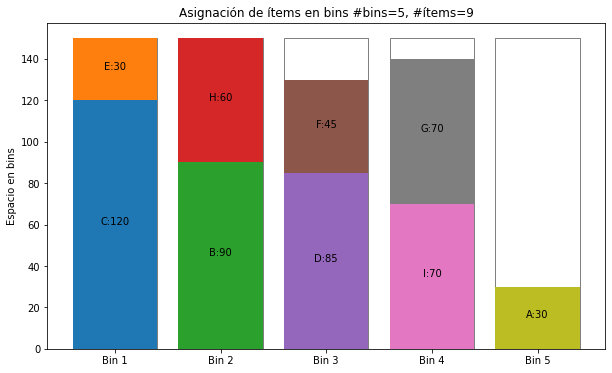

In [ ]:
# Cromosoma de prueba
test_c = [2, 4, 1, 7, 3, 5, 8, 6, 0] 

# Pool de ítems de muestra
test_items_pool = [Item('A', 30), Item('B', 90), Item('C',120), Item('D',85), Item('E',30), Item('F',45), Item('G',70), Item('H',60), Item('I',70)]

# Se calcula el fitness para el ejemplo
f  = fitness_items_bins(test_c, test_items_pool, [150,150,150,150,150])
print(f'fitness: {f}')

# Mostramos el cromosoma con la representación en el objeto BIns
bins = Bins([150,150,150,150,150], chromosome_to_item_list(test_c, test_items_pool))
bins.plot()

Función para evaluar toda una población de individuos con la funcion de fitnes especificada

In [ ]:
def evaluate_population(bins_max_sizes, items_pool, population, fitness_fn):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    for i in range(len(population)):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome, items_pool, bins_max_sizes)
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [ ]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [ ]:
def select_parents_torneo(population,size_torneo):
    
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:size_torneo]
    for i in range(size_torneo):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

## Seleccion de sobrevivientes por Ranking

#### Seleccion de sobrevivientes por ranking

In [ ]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

## Algoritmo Genetico
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen), metodoSeleccion (ruleta/torneo), tournament_size, taza de mutación (pmut), operador de cruzamiento (crossover) y operador de mutacion (mutation)

In [ ]:
def genetic_algorithm(bin_max_heights, items, 
                      poblacion_inicial, fitness_fn, ngen=100, pmut=0.1, tournament_size=3,
                      crossover="onepoint", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico para el problema de items asignados a bins
        bin_max_sizes:  Lista con tamaño de los bins
        items (list[Item]): Lista con el pool de ítems disponibles
        ngen (int):       maximo numero de generaciones 
        pmut (float):       tasa de mutacion
        crossover (str):  operador de cruzamiento
        mutation (str):   operador de mutacion
        selection_parents_method (str): método de selección de padres para cruzamiento
        selection_survivors_method (str): método de selección de sobrevivientes 
    """
    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial
    
    popsize = len(population)
    
    # Se evalúa la poblacion inicial
    evaluate_population(bin_max_heights, items, population, fitness_fn)  

    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))

    # Iteración por cada número de generaciones
    for g in range(ngen):   
        
        ## Selecciona las parejas de padres (mating pool) para cruzamiento 
        mating_pool = []
        if selection_parents_method=="roulette":
            for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        elif selection_parents_method=="tournament" :
            for i in range(int(popsize/2)): mating_pool.append(select_parents_torneo(population,tournament_size))
        else:
            raise NotImplementedError
                
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":# cruzamiento 1 punto
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) 
            elif crossover == "uniform":# cruzamiento uniforme
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) 
            elif crossover == "orderpermutation":# cruzamiento uniforme
                offspring_population.extend( mating_pool[i][0].crossover_orderpermutation(mating_pool[i][1]) ) 
            else:
                raise NotImplementedError                
           
        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "position":
                    offspring_population[i] = offspring_population[i].mutate_position()   # mutacion de una posicion
                elif mutation == "swap":
                    offspring_population[i] = offspring_population[i].mutate_swap()      # mutacion swap
                elif mutation =='insertion':
                    offspring_population[i] = offspring_population[i].mutate_insertion() 
                else:
                    raise NotImplementedError
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(bin_max_heights, items, offspring_population, fitness_fn)  
        
        ## Selecciona popsize individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError        
  
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        print("generacion {}, best_fitness = {},best_cromosoma = {}".format(g, population[ibest[0]].fitness,population[ibest[0]].chromosome))
    
    return population[ibest[0]], bestfitness  

## Probando el Algoritmo genetico

Llama al algoritmo genetico para encontrar una solucion al problema de asignación de ítems en bins

Se han generado 15 items: 
 - A:80
 - B:25
 - C:20
 - D:110
 - E:100
 - F:25
 - G:10
 - H:45
 - I:35
 - J:90
 - K:90
 - L:110
 - M:100
 - N:10
 - O:55

Población inicial:
 - [1 6 8 14 13 10 9 0 7 3 5 4 12 11 2]
 - [3 14 1 12 7 5 13 6 11 8 2 4 0 9 10]
 - [4 10 1 5 8 6 11 9 0 14 7 13 12 3 2]
 - [1 10 6 12 2 3 11 5 7 13 14 0 4 9 8]
 - [1 6 7 14 3 13 9 5 2 12 10 4 0 8 11]
 - [0 10 4 8 9 2 12 1 5 7 11 3 14 6 13]
 - [3 2 6 11 0 12 10 13 5 4 14 7 9 1 8]
 - [7 14 0 2 6 9 8 11 10 4 3 1 5 12 13]
 - [14 10 8 13 1 4 7 3 12 0 5 2 6 9 11]
 - [3 0 12 4 13 8 14 11 10 2 6 7 5 9 1]
Poblacion inicial, best_fitness = 235
generacion 0, best_fitness = 261,best_cromosoma = [7, 0, 6, 14, 9, 10, 8, 4, 1, 3, 5, 13, 12, 11, 2]
generacion 1, best_fitness = 261,best_cromosoma = [7, 0, 6, 14, 9, 10, 8, 4, 1, 3, 5, 13, 12, 11, 2]
generacion 2, best_fitness = 261,best_cromosoma = [7, 0, 6, 14, 9, 10, 8, 4, 1, 3, 5, 13, 12, 11, 2]
generacion 3, best_fitness = 261,best_cromosoma = [7, 0, 6, 14, 9, 10, 8, 4, 1, 3, 5, 13

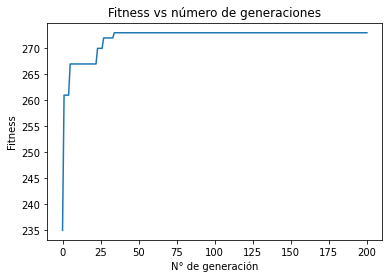

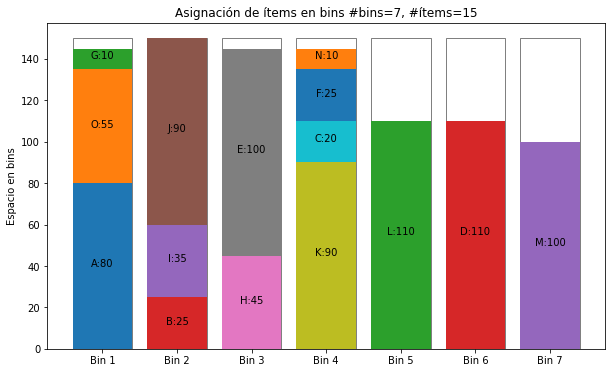

In [ ]:
# Se defina los tamaños máximos de los BINS
BINS_MAX_SIZES = [150, 150, 150, 150, 150, 150, 150]

# Se define el pool de ítem
NUM_ITEMS = 15 
ITEMS = generate_items(NUM_ITEMS, 120)
#ITEMS = [Item('A',30), Item('B',90), Item('C', 120), Item('D',85), Item('E', 30), Item ('F',45),Item('G',60),  Item ('H',60), Item('I',70)]
print(f'Se han generado {NUM_ITEMS} items: ')
for item in ITEMS:
  print(' - ', end='')
  print(item)

# Inicializamos la población inicial
# Notar que los cromosomas tiene el mismo tamaño que la cantidad de ítems
size_chromosoma = len(ITEMS)   
num_individuals = 10

poblacion_inicial = init_population(num_individuals, size_chromosoma)
print("\nPoblación inicial:")
for p in poblacion_inicial:
  print(" - ", end='')
  print(p)

# Definición de los parámetros para el AG
ngen = 200 # Nro de generaciones
pmut = 0.8 # taza de mutación
fitness_fn=fitness_items_bins

metodoSeleccion=['roulette','tournament']
tournament_size = 3 

crossover=['onepoint','uniform', 'orderpermutation']
mutation=['position','swap', 'insertion']


lst_bestcrom=[]
best_ind, bestfitness = genetic_algorithm(BINS_MAX_SIZES, ITEMS,
                                          poblacion_inicial, fitness_fn, ngen, pmut, tournament_size, 
                                          'orderpermutation', 'insertion', 'roulette')
lst_bestcrom.append(best_ind)
plt.plot(bestfitness)
plt.ylabel('Fitness')
plt.xlabel('N° de generación')
plt.title('Fitness vs número de generaciones')
plt.show()

# Se muestra el mejor cromosoma en el gráfico de bins
print()
bins = Bins(BINS_MAX_SIZES, chromosome_to_item_list(best_ind.chromosome, ITEMS))
bins.plot()

# Experimentación:


## 1) Comparar el desempeño de los operadores de cruzamiento

CONSIDERACIONES:

    - Hacer experimentos para cada configuración de bins con cada configuración de número de ítems
    - Tasa de mutación = 0
    - Realizar 10 corridas de cada combinación
    - Generar una poblacion inicial P de 10 individuos 
    - Ejecutar el AG con poblacion inicial P y metodo de cruzamiento uniform
    - Ejecutar el AG con poblacion inicial P y metodo de cruzamiento orderpermutation
    - En ambas ejecuciones registre el fitness máximo obtenido y la primera generacion donde se obtiene dicho fitness

Los parametros del AG para cada corrida son 10 individuos, 200 generaciones, seleccion de padres = 'roulette'


In [ ]:
# Se defina ejemplos de conjuntos de bins
BINS_MAX_SIZES_EXAMPLES = [
    [150, 150, 150, 150, 150, 150, 150, 150,150],
    [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
    [150, 120, 200, 300, 190, 100, 50, 130, 100,80]
]

# Se define la cantidad de ítems que se van a generar en las iteraciones
NUM_ITEMS_VALUES = [10, 15, 20] 

# Se define los parámetros del algoritmo genético
fitness_fn = fitness_items_bins
ngen = 200
pmut = 0
metodo_seleccion = 'roulette'
crossover = ['uniform','orderpermutation']
mutation = ['position','swap', 'insertion']
num_individuals = 10

# Dataframe para guardar todos los resultados del AG
df = pd.DataFrame()

# Se crea un diccionario que guardará las listas de ítems creadas en las iteraciones
items_examples_dict = {}

In [ ]:
# Se realiza las iteraciones 
for bins_max_sizes in BINS_MAX_SIZES_EXAMPLES:

  concated = ','.join(str(bin) for bin in bins_max_sizes)
  bins_name = f'[{concated}]'

  print('*'*30)
  print(f'BINS: {bins_name}')

  for num_items in NUM_ITEMS_VALUES:
    
    print('+'*30)

    # Se genera el pool de ítems
    items = generate_items(num_items, max(bins_max_sizes))
    print(f'Se han generado {NUM_ITEMS} items: ')
    for item in ITEMS:
      print(' - ', end='')
      print(item)
    # Se guarda la lista de ítems generada
    items_examples_dict[bins_name + '-' +str(num_items)] = items

    # Inicializamos la población inicial
    size_chromosoma = len(items)   

    population = init_population(num_individuals, size_chromosoma)
    print("\nPoblación inicial:")
    for p in poblacion_inicial:
      print(" - ", end='')
      print(p)

    # Se realiza 10 iteraciones de cada combinación
    for i in range(10):    
        # Ejecución con uniform  
        best_ind, best_fitness = genetic_algorithm(bins_max_sizes, items,
                                                  population, fitness_fn, ngen, pmut, tournament_size, crossover[0], mutation[0], metodo_seleccion)
        max_fitness_uniform = max(best_fitness)
        n_generacion_convergencia_uniform = best_fitness.index(max_fitness_uniform)

        df = df.append({'i':i, 'crossover': crossover[0], 
                        'maximo_fitness': max_fitness_uniform, 
                        'n_generacion_convergencia': n_generacion_convergencia_uniform, 
                        'mejor_individuo': best_ind.chromosome,
                        'num_items': num_items,
                        'bins': bins_name
                        }, ignore_index=True)

        # Ejecución con order permutation  
        best_ind, best_fitness = genetic_algorithm(bins_max_sizes, items,
                                                  population, fitness_fn, ngen, pmut, tournament_size, crossover[1], mutation[0], metodo_seleccion)
        max_fitness_op = max(best_fitness)
        n_generacion_convergencia_op = best_fitness.index(max_fitness_op)
        df = df.append({'i':i, 'crossover': crossover[1], 
                        'maximo_fitness': max_fitness_op, 
                        'n_generacion_convergencia': n_generacion_convergencia_op, 
                        'mejor_individuo': best_ind.chromosome,
                        'num_items': num_items,
                        'bins': bins_name
                        }, ignore_index=True)

Se han truncado las últimas 5000 líneas del flujo de salida.
generacion 53, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 54, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 55, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 56, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 57, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 58, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 59, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 60, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 61, best_fitness = 405,best_cromosoma = [9, 6, 13, 1, 12, 4, 3, 0, 14, 10, 8, 5, 11, 2, 7]
generacion 62, best_f

In [ ]:
df.groupby(['bins', 'num_items', 'crossover'])[['maximo_fitness', 'n_generacion_convergencia']].mean()

maximo_fitness  \
bins                                          num_items crossover                          
[100,100,100,100,100,100,100,100,100,100,100] 10.0      orderpermutation           553.4   
                                                        uniform                    534.6   
                                              15.0      orderpermutation           572.6   
                                                        uniform                    536.0   
                                              20.0      orderpermutation           638.0   
                                                        uniform                    548.0   
[150,120,200,300,190,100,50,130,100,80]       10.0      orderpermutation           318.1   
                                                        uniform                    306.6   
                                              15.0      orderpermutation           433.7   
                                                        uniform                    242.0   
                                              20.0      orderpermutation           419.5   
                                                        uniform                    274.0   
[150,150,150,150,150,150,150,150,150]         10.0      orderpermutation           318.2   
                                                        uniform                    312.5   
                                              15.0      orderpermutation           433.1   
                                                        uniform                    380.0   
                                              20.0      orderpermutation           443.0   
                                                        uniform                    428.0   

                                                                          n_generacion_convergencia  
bins                                          num_items crossover                                    
[100,100,100,100,100,100,100,100,100,100,100] 10.0      orderpermutation                       11.3  
                                                        uniform                                 8.4  
                                              15.0      orderpermutation                       34.8  
                                                        uniform                                14.4  
                                              20.0      orderpermutation                       35.6  
                                                        uniform                                 0.0  
[150,120,200,300,190,100,50,130,100,80]       10.0      orderpermutation                        5.6  
                                                        uniform                                 5.9  
                                              15.0      orderpermutation                       21.7  
                                                        uniform                                 0.0  
                                              20.0      orderpermutation                       17.9  
                                                        uniform                                 0.0  
[150,150,150,150,150,150,150,150,150]         10.0      orderpermutation                       14.8  
                                                        uniform                                 2.7  
                                              15.0      orderpermutation                       22.3  
                                                        uniform                                18.3  
                                              20.0      orderpermutation                       26.5  
                                                        uniform                                 0.0

Mostramos algunos ejemplos de las mejores soluciones:

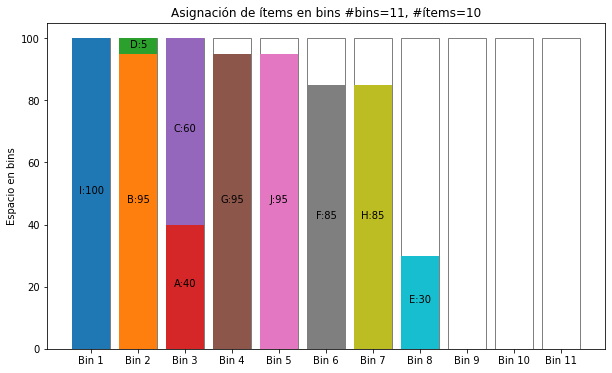

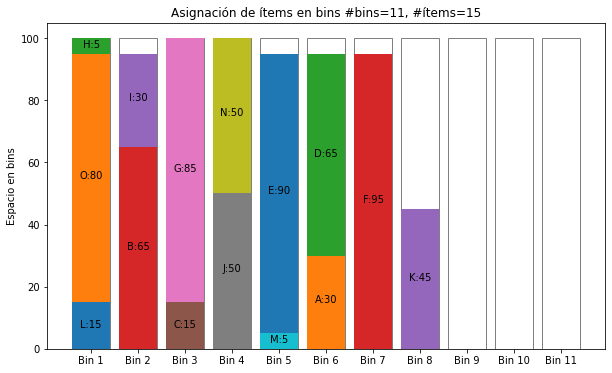

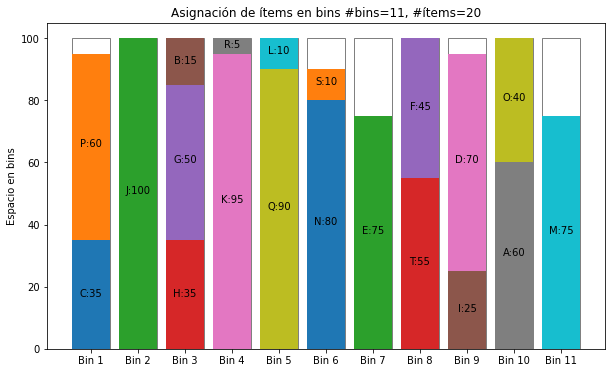

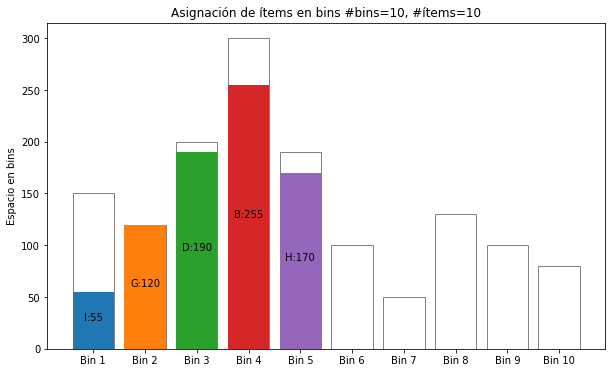

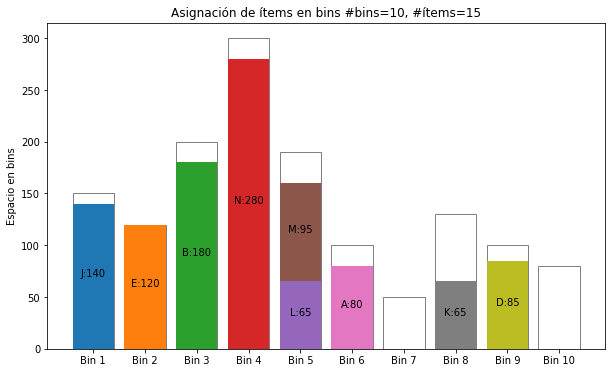

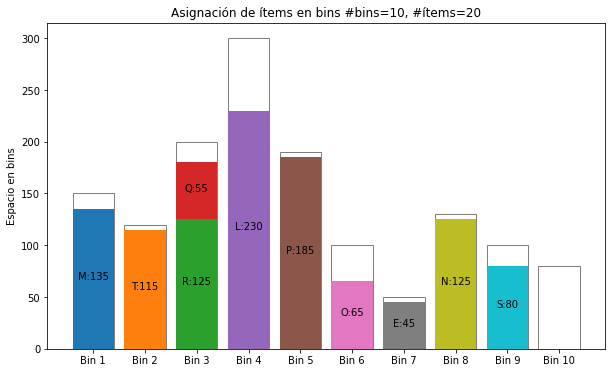

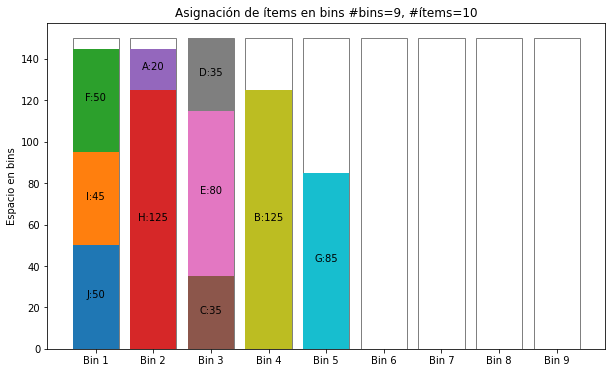

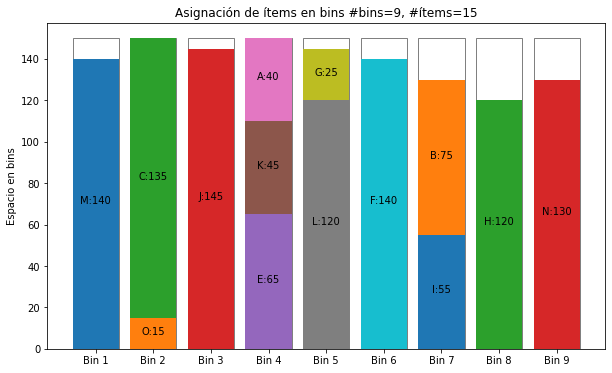

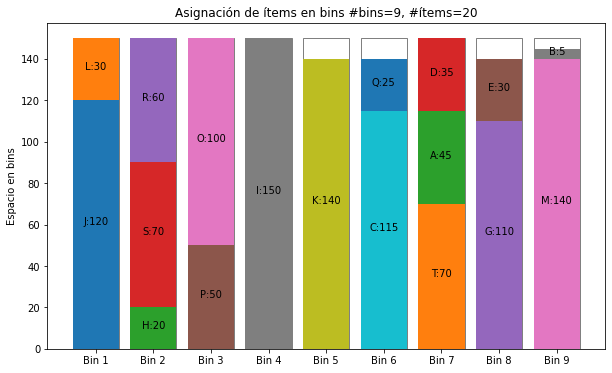

In [ ]:
for bins_name, group in df.groupby(['bins']):
  for num_items, subgroup in group.groupby(['num_items']):
    num_items = int(num_items)
    # Se ordena en función del fitness para tener el mejor cromosoma
    subgroup = subgroup.sort_values(by=['maximo_fitness'], ascending=[False])
    best_fitness_row = subgroup.iloc[0]

    best_chromosome = best_fitness_row['mejor_individuo']

    # Se compone la clave para acceder al diccionario de ítems
    key = f'{bins_name}-{num_items}'

    # Se obtiene el pool de ítems correspondiente
    items = items_examples_dict[key]

    bins = [int(x) for x in bins_name[1:-1].split(',')]

    # Mostramos el cromosoma con la representación en el objeto BIns
    bins = Bins(bins, chromosome_to_item_list(best_chromosome, items))
    bins.plot()

**Conclusión:**

El operador **order permutation** es el que tiende a encontrar una solución con mejor fitness. Para los casos experimentados, siempre generó valores iguales o mayores comparados con el operador **uniform**. Por otro lado, el operador **uniform** convergio más rápido, pero esto no quiere decir que encontró una mejor solución comparado con el operador **order permutation**.

La razón principal de esto es debido a que el operador **uniform** no respeta la permutación del cromosoma y repite los genes, lo que evita que se genere una mejor solución. Mientras que el operador **order permutation** respeta la permutación y genera mayores variantes del cromosoma, lo que ayuda a encontrar más rápidamente una mejor solución, obteniendo un mejor fitness.

Tener en cuenta que para el problema de "asignación de ítems", una solución equivocada o no admisible es aquella donde hay genes repetidos. Puesto que esto significa que se está colocando un ítems en 2 lugares al mismo. Este caso puede presentarse varias veces con el operador **uniform**, y nunca presentarse con el operador **order permutation**.

## 2) Determinar la influencia de la mutación

Consideraciones:

    - Hacer experimentos para cada configuración de bins con cada configuración de número de ítems
    - Realizar 10 corridas por cada experimento
    - Ejecutar el AG con poblacion inicial P, cruzamiento uniform y mutacion mutation_insertion (pmut=0.20)
    - Ejecutar el AG con poblacion inicial P, cruzamiento uniform y mutacion mutation_insertion (pmut=0.80)
    - Ejecutar el AG con poblacion inicial P, cruzamiento orderpermutation y mutate_swap (pmut=0.20)
    - Ejecutar el AG con poblacion inicial P, cruzamiento orderpermutation y mutate_swap (pmut=0.80)
    - En todas las ejecuciones registre el fitness máximo obtenido y la primera generacion donde se obtiene dicho fitness
    - 10 invidividuos de poiblación P
    - 200 generaciones
 

In [ ]:
# Se defina ejemplos de conjuntos de bins
BINS_MAX_SIZES_EXAMPLES = [
    [150, 150, 150, 150, 150, 150, 150, 150,150],
    [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
    [150, 120, 200, 300, 190, 100, 50, 130, 100,80]
]

# Se define la cantidad de ítems que se van a generar en las iteraciones
NUM_ITEMS_VALUES = [10, 15, 20] 

# Se define los parámetros del algoritmo genético
fitness_fn = fitness_items_bins
ngen = 200
pmut = [0.20, 0.80]
metodo_seleccion = 'roulette'
crossover = ['uniform','orderpermutation']
mutation = ['insertion', 'swap']
num_individuals = 10

# Dataframe para guardar todos los resultados del AG
df = pd.DataFrame()

# Se crea un diccionario que guardará las listas de ítems creadas en las iteraciones
items_examples_dict = {}

In [ ]:
# Se realiza las iteraciones 
for bins_max_sizes in BINS_MAX_SIZES_EXAMPLES:

  concated = ','.join(str(bin) for bin in bins_max_sizes)
  bins_name = f'[{concated}]'

  print('*'*30)
  print(f'BINS: {bins_name}')

  for num_items in NUM_ITEMS_VALUES:
    
    print('+'*30)

    # Se genera el pool de ítems
    items = generate_items(num_items, max(bins_max_sizes))
    print(f'Se han generado {NUM_ITEMS} items: ')
    for item in ITEMS:
      print(' - ', end='')
      print(item)
    # Se guarda la lista de ítems generada
    items_examples_dict[bins_name + '-' +str(num_items)] = items

    # Inicializamos la población inicial
    size_chromosoma = len(items)   

    population = init_population(num_individuals, size_chromosoma)
    print("\nPoblación inicial:")
    for p in poblacion_inicial:
      print(" - ", end='')
      print(p)

    # Se realiza 10 iteraciones de cada combinación
    for i in range(10):   

        #Ejecución con crossover=uniform, mutation=insertion y pmut=0.20
        best_ind, best_fitness = genetic_algorithm(bins_max_sizes, items, population, fitness_fn, ngen, pmut[0], tournament_size, crossover[0], mutation[0], metodo_seleccion)
        df = df.append({'i':i, 'crossover': crossover[0], 
                        'mutation': mutation[0], 
                        'pmut': pmut[0],
                        'maximo_fitness': max(best_fitness),
                        'n_generacion_convergencia': best_fitness.index(max(best_fitness)), 
                        'mejor_individuo': best_ind.chromosome,
                        'num_items': num_items,
                        'bins': bins_name
                        }, ignore_index=True)

        #Ejecución con crossover=uniform, mutation=insertion y pmut=0.80
        best_ind, best_fitness = genetic_algorithm(bins_max_sizes, items, population, fitness_fn, ngen, pmut[1], tournament_size, crossover[0], mutation[0], metodo_seleccion)
        df = df.append({'i':i, 'crossover': crossover[0], 
                        'mutation': mutation[0], 
                        'pmut': pmut[1],
                        'maximo_fitness': max(best_fitness), 
                        'n_generacion_convergencia': best_fitness.index(max(best_fitness)), 
                        'mejor_individuo': best_ind.chromosome,
                        'num_items': num_items,
                        'bins': bins_name
                        }, ignore_index=True)
        
        #Ejecución con crossover=orderpermutation, mutation=swap y pmut=0.20
        best_ind, best_fitness = genetic_algorithm(bins_max_sizes, items,population, fitness_fn, ngen, pmut[0], tournament_size, crossover[1], mutation[1], metodo_seleccion)
        df = df.append({'i':i, 'crossover': crossover[1], 
                        'mutation': mutation[1], 
                        'pmut': pmut[0],
                        'maximo_fitness': max(best_fitness), 
                        'n_generacion_convergencia': best_fitness.index(max(best_fitness)), 
                        'mejor_individuo': best_ind.chromosome,
                        'num_items': num_items,
                        'bins': bins_name
                        }, ignore_index=True)

        #Ejecución con crossover=orderpermutation, mutation=swap y pmut=0.80
        best_ind, best_fitness = genetic_algorithm(bins_max_sizes, items, population, fitness_fn, ngen, pmut[1], tournament_size, crossover[1], mutation[1], metodo_seleccion)
        df = df.append({'i':i, 'crossover': crossover[1], 
                        'mutation': mutation[1], 
                        'pmut': pmut[1],
                        'maximo_fitness': max(best_fitness), 
                        'n_generacion_convergencia': best_fitness.index(max(best_fitness)), 
                        'mejor_individuo': best_ind.chromosome,
                        'num_items': num_items,
                        'bins': bins_name
                        }, ignore_index=True)

Se han truncado las últimas 5000 líneas del flujo de salida.
generacion 24, best_fitness = 458,best_cromosoma = [17, 13, 6, 1, 15, 3, 16, 2, 5, 18, 0, 4, 12, 11, 8, 10, 19, 7, 9, 14]
generacion 25, best_fitness = 467,best_cromosoma = [17, 13, 6, 1, 14, 10, 8, 15, 16, 0, 18, 2, 12, 5, 3, 11, 4, 19, 9, 7]
generacion 26, best_fitness = 467,best_cromosoma = [17, 13, 6, 1, 14, 10, 8, 15, 16, 0, 18, 2, 12, 5, 3, 11, 4, 19, 9, 7]
generacion 27, best_fitness = 475,best_cromosoma = [17, 13, 6, 1, 14, 16, 8, 15, 10, 0, 18, 2, 12, 19, 3, 11, 4, 5, 9, 7]
generacion 28, best_fitness = 475,best_cromosoma = [17, 13, 6, 1, 14, 16, 8, 15, 10, 0, 18, 2, 12, 19, 3, 11, 4, 5, 9, 7]
generacion 29, best_fitness = 475,best_cromosoma = [17, 13, 6, 1, 14, 16, 8, 15, 10, 0, 18, 2, 12, 19, 3, 11, 4, 5, 9, 7]
generacion 30, best_fitness = 479,best_cromosoma = [17, 13, 6, 1, 14, 15, 16, 8, 10, 18, 2, 0, 3, 12, 5, 11, 4, 19, 9, 7]
generacion 31, best_fitness = 479,best_cromosoma = [17, 13, 6, 1, 14, 15, 16, 8, 10, 

In [ ]:
df.groupby(['bins', 'num_items', 'crossover','mutation', 'pmut'])[['maximo_fitness', 'n_generacion_convergencia']].mean()

maximo_fitness  \
bins                                          num_items crossover        mutation  pmut                   
[100,100,100,100,100,100,100,100,100,100,100] 10.0      orderpermutation swap      0.2            473.2   
                                                                                   0.8            473.4   
                                                        uniform          insertion 0.2            470.9   
                                                                                   0.8            470.6   
                                              15.0      orderpermutation swap      0.2            579.6   
                                                                                   0.8            582.4   
                                                        uniform          insertion 0.2            539.9   
                                                                                   0.8            544.2   
                                              20.0      orderpermutation swap      0.2            644.9   
                                                                                   0.8            648.4   
                                                        uniform          insertion 0.2            570.0   
                                                                                   0.8            570.0   
[150,120,200,300,190,100,50,130,100,80]       10.0      orderpermutation swap      0.2            368.8   
                                                                                   0.8            373.8   
                                                        uniform          insertion 0.2            377.8   
                                                                                   0.8            378.1   
                                              15.0      orderpermutation swap      0.2            496.1   
                                                                                   0.8            500.6   
                                                        uniform          insertion 0.2            322.8   
                                                                                   0.8            313.2   
                                              20.0      orderpermutation swap      0.2            510.7   
                                                                                   0.8            519.4   
                                                        uniform          insertion 0.2            298.0   
                                                                                   0.8            303.9   
[150,150,150,150,150,150,150,150,150]         10.0      orderpermutation swap      0.2            361.2   
                                                                                   0.8            361.5   
                                                        uniform          insertion 0.2            351.9   
                                                                                   0.8            354.8   
                                              15.0      orderpermutation swap      0.2            338.8   
                                                                                   0.8            338.9   
                                                        uniform          insertion 0.2            333.0   
                                                                                   0.8            333.0   
                                              20.0      orderpermutation swap      0.2            450.8   
                                                                                   0.8            449.8   
                                                        uniform          insertion 0.2            397.0   
                                                                                   0.8            397.0   

                      

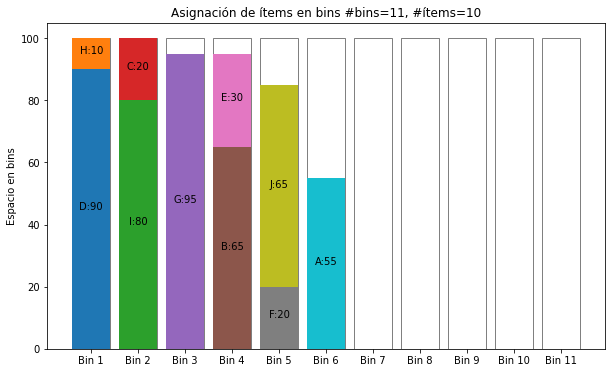

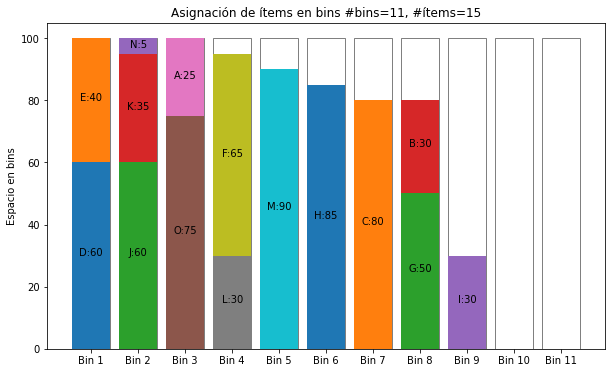

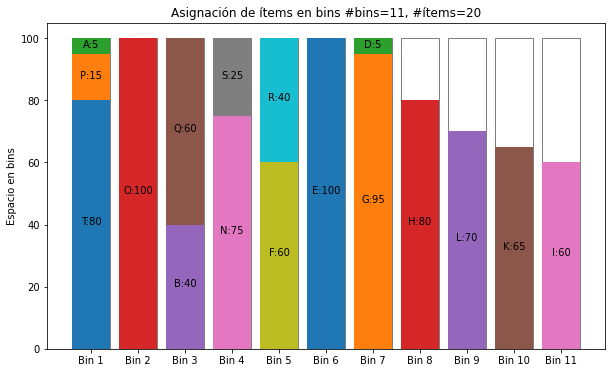

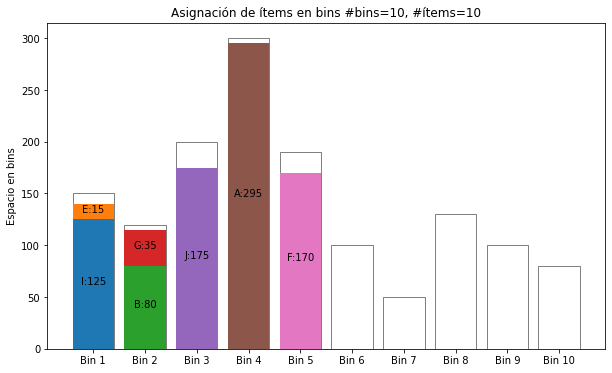

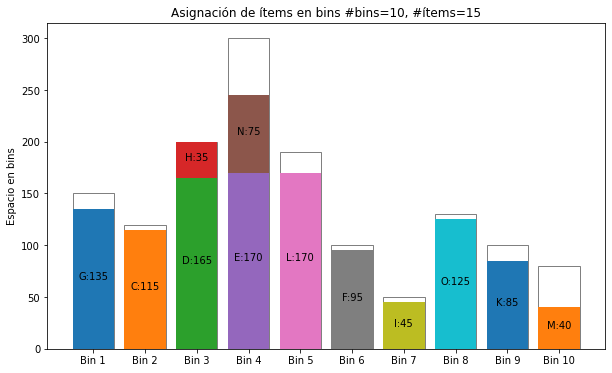

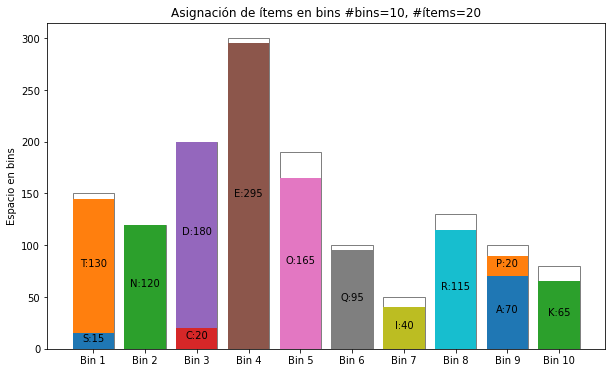

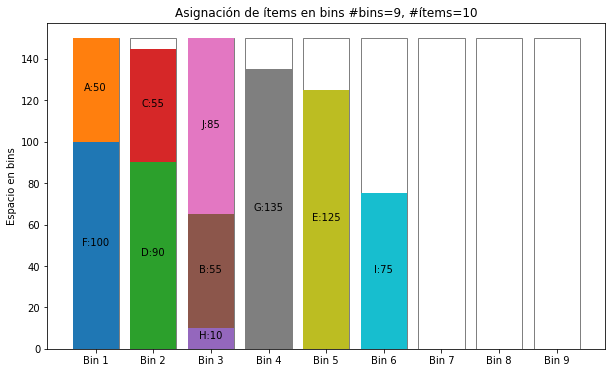

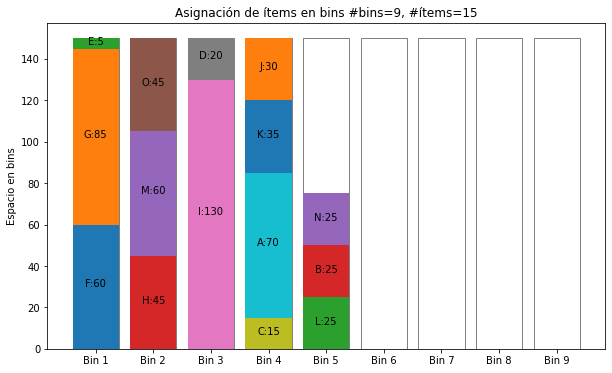

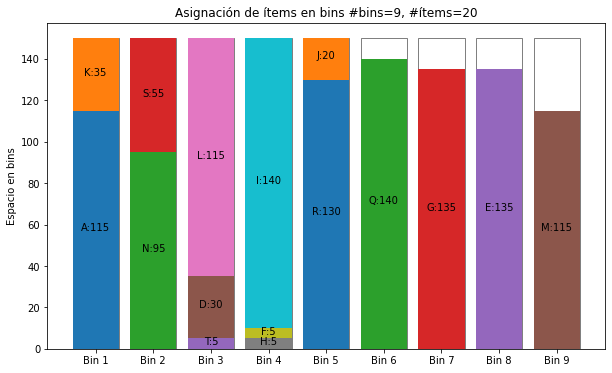

In [ ]:
for bins_name, group in df.groupby(['bins']):
  for num_items, subgroup in group.groupby(['num_items']):
    num_items = int(num_items)
    # Se ordena en función del fitness para tener el mejor cromosoma
    subgroup = subgroup.sort_values(by=['maximo_fitness'], ascending=[False])
    best_fitness_row = subgroup.iloc[0]

    best_chromosome = best_fitness_row['mejor_individuo']

    # Se compone la clave para acceder al diccionario de ítems
    key = f'{bins_name}-{num_items}'

    # Se obtiene el pool de ítems correspondiente
    items = items_examples_dict[key]

    bins = [int(x) for x in bins_name[1:-1].split(',')]

    # Mostramos el cromosoma con la representación en el objeto BIns
    bins = Bins(bins, chromosome_to_item_list(best_chromosome, items))
    bins.plot()

**Conclusión:**

La combinación de operadores **order permutation-swap** es el que tiende a encontrar una solución con mejor fitness. Para los casos experimentados, siempre generó valores iguales o mayores comparados con el operador **uniform-insertion**. Era de esperarse este resultado, pues para este ejercicio de "asignación de ítems", **order permutation** siempre será superior a **uniform** por las razones comentadas en el ejercicio anterior. En esta experimentación, el impacto de usar **swap** y **insertion** no es mucha porque están emparejados con **order permutation** y **uniform** respectivamente.

Por otro lado, independientemente de los operadores, se ve que a menor **tasa de mutación**, más rápido es la convergencia, y a mayor **tasa de mutación**, mejor es el fitness. La **tasa de mutación** es la probabilidad de que una mutación se efectúe en el algoritmo, por lo tanto, si es alto, se puede decir que habrá mayor variedad de individuos, lo que explica el mejor fitness y la demora en la convergencia para este ejercicio.